In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

final_df = pd.read_csv('../dataset/final_experiment_avg_df.csv')


final_df_160_0 = final_df[(final_df['velocity'] == 160) & (final_df['position'] == 0)]
final_df_160_0.drop(['velocity', 'position', 'experiment_number', 'displacement', 'id', 'Period'], axis=1, inplace=True)

average_difference = int(final_df_160_0['Cycle_Number'].diff().mean())

# Generate new Cycle_Number values with constant frequency
final_df_160_0['Cycle_Number'] = final_df_160_0['Cycle_Number'].iloc[0] + np.arange(len(final_df_160_0)) * average_difference

final_df_160_0_original = final_df_160_0.copy()

C:\Users\alira\AppData\Local\Temp\ipykernel_14860\3978173648.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_160_0.drop(['velocity', 'position', 'experiment_number', 'displacement', 'id', 'Period'], axis=1, inplace=True)
C:\Users\alira\AppData\Local\Temp\ipykernel_14860\3978173648.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_160_0['Cycle_Number'] = final_df_160_0['Cycle_Number'].iloc[0] + np.arange(len(final_df_160_0)) * average_difference


In [4]:
final_df_160_0.set_index('Cycle_Number', inplace=True)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [8]:
scaler = MinMaxScaler()
final_df_160_0_scaled = scaler.fit_transform(final_df_160_0)

# Create sequences and labels for training
seq_length = 24
X, y = [], []
for i in range(len(final_df_160_0_scaled) - seq_length):
    X.append(final_df_160_0_scaled[i:i + seq_length])
    y.append(final_df_160_0_scaled[i + seq_length])

X, y = np.array(X), np.array(y)

# Split the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



# Create a custom dataset class for PyTorch DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 128
output_size = 1
learning_rate = 0.001
num_epochs = 500
batch_size = 64

# Create data loaders
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Training the model
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/500], Loss: 0.0168
Epoch [20/500], Loss: 0.0152
Epoch [30/500], Loss: 0.0045
Epoch [40/500], Loss: 0.0042
Epoch [50/500], Loss: 0.0044
Epoch [60/500], Loss: 0.0041
Epoch [70/500], Loss: 0.0040
Epoch [80/500], Loss: 0.0036
Epoch [90/500], Loss: 0.0031
Epoch [100/500], Loss: 0.0055
Epoch [110/500], Loss: 0.0029
Epoch [120/500], Loss: 0.0027
Epoch [130/500], Loss: 0.0027
Epoch [140/500], Loss: 0.0032
Epoch [150/500], Loss: 0.0029
Epoch [160/500], Loss: 0.0045
Epoch [170/500], Loss: 0.0039
Epoch [180/500], Loss: 0.0042
Epoch [190/500], Loss: 0.0038
Epoch [200/500], Loss: 0.0038
Epoch [210/500], Loss: 0.0030
Epoch [220/500], Loss: 0.0036
Epoch [230/500], Loss: 0.0043
Epoch [240/500], Loss: 0.0036
Epoch [250/500], Loss: 0.0033
Epoch [260/500], Loss: 0.0034
Epoch [270/500], Loss: 0.0043
Epoch [280/500], Loss: 0.0040
Epoch [290/500], Loss: 0.0034
Epoch [300/500], Loss: 0.0029
Epoch [310/500], Loss: 0.0034
Epoch [320/500], Loss: 0.0038
Epoch [330/500], Loss: 0.0034
Epoch [340/500], Lo

In [9]:
# Evaluation on the test set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred = model(X_test_tensor).numpy()
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



Root Mean Squared Error (RMSE): 1.9687005075178587e-06
Mean Absolute Error (MAE): 0.00
Mean Absolute Percentage Error (MAPE): 1.07%


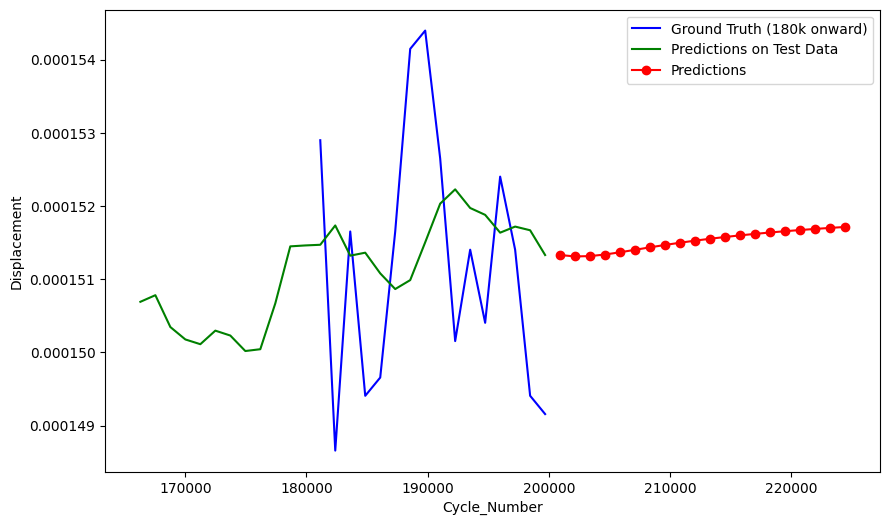

In [28]:
import torch

# Number of points you want to predict
num_predictions = 20

# Start with the last sequence from the test data
input_seq = torch.tensor(X_test[-1].reshape(1, seq_length, input_size), dtype=torch.float32)  # Convert to tensor and reshape
predictions = []

# Predict on the test data
test_predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        input_seq = torch.tensor(X_test[i].reshape(1, seq_length, input_size), dtype=torch.float32)
        prediction = model(input_seq)
        test_predictions.append(prediction.item())

# Convert test predictions back to the original scale
test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test).flatten()

model.eval()  
with torch.no_grad():
    for _ in range(num_predictions):
        prediction = model(input_seq)
        
        predictions.append(prediction.item())
        
        new_input = torch.cat((input_seq[0, 1:], prediction), dim=0)
        input_seq = new_input.unsqueeze(0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

test_cycle_numbers = final_df_160_0.index[-len(y_test_original):]
last_cycle_number = final_df_160_0.index[-1]
future_cycle_numbers = last_cycle_number + np.arange(1, num_predictions + 1) * average_difference

start_cycle_number = 180000 
filtered_df = final_df_160_0_original[final_df_160_0_original['Cycle_Number'] >= start_cycle_number]


plt.figure(figsize=(10, 6))

plt.plot(filtered_df['Cycle_Number'], filtered_df['smoothed_displacement'], label="Ground Truth (180k onward)", color="blue")
plt.plot(test_cycle_numbers, test_predictions, label="Predictions on Test Data", color="green")
plt.plot(future_cycle_numbers, predictions, color='red', marker='o', label='Predictions')

plt.xlabel('Cycle_Number')
plt.ylabel('Displacement')
plt.legend()
plt.show()



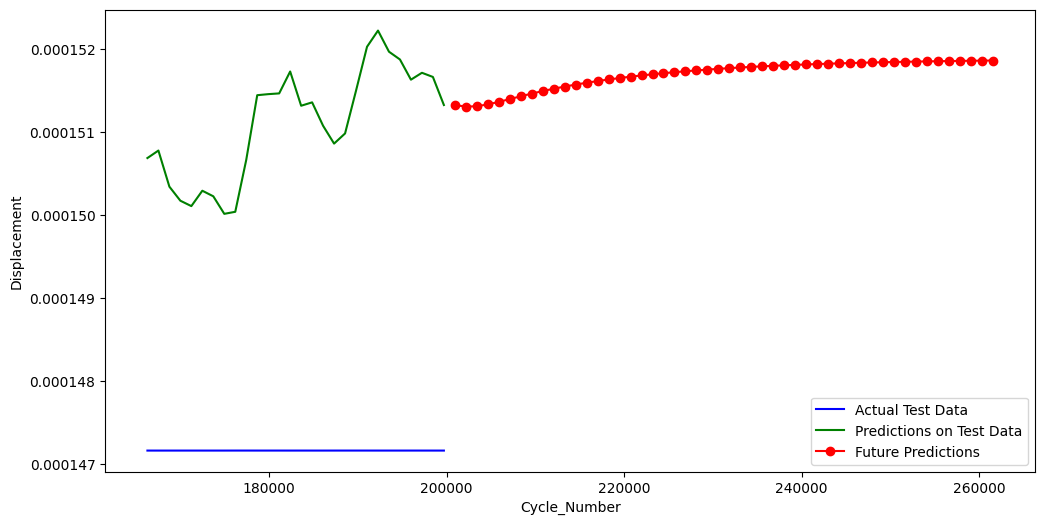

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Predict on the test data
test_predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        input_seq = torch.tensor(X_test[i].reshape(1, seq_length, input_size), dtype=torch.float32)
        prediction = model(input_seq)
        test_predictions.append(prediction.item())

# Convert test predictions back to the original scale
test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test).flatten()

# Start predicting future points beyond the test data
num_predictions = 50  # Number of future predictions
input_seq = torch.tensor(X_test[-1].reshape(1, seq_length, input_size), dtype=torch.float32)  # Start with last test sequence
future_predictions = []

with torch.no_grad():
    for _ in range(num_predictions):
        prediction = model(input_seq)
        future_predictions.append(prediction.item())
        
        # Update the sequence by adding the new prediction and removing the oldest value
        new_input = torch.cat((input_seq[0, 1:], prediction), dim=0)
        input_seq = new_input.unsqueeze(0)

# Inverse transform the future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Combine cycle numbers for plotting
test_cycle_numbers = final_df_160_0.index[-len(y_test_original):]
last_cycle_number = test_cycle_numbers[-1]  # Last cycle number in the test data
future_cycle_numbers = last_cycle_number + np.arange(1, num_predictions + 1) * average_difference

# Plot the actual test data, test predictions, and future predictions
plt.figure(figsize=(12, 6))
plt.plot(test_cycle_numbers, y_test_original, label="Actual Test Data", color="blue")
plt.plot(test_cycle_numbers, test_predictions, label="Predictions on Test Data", color="green")
plt.plot(future_cycle_numbers, future_predictions, color='red', marker='o', label='Future Predictions')
plt.xlabel('Cycle_Number')
plt.ylabel('Displacement')
plt.legend()
plt.show()
